In [1]:
from mynotebooks import *
%matplotlib inline

arm = Box2DWorld.Arm(position=(0,0), nparts=3, bHand = False)  # Arm creation
fig, ax = Box2DWorld.makeFigure()

### Sensorimotor mapping :  $f(S, \Delta M) = \langle S, \Delta S \rangle$ with context

In [2]:
joint_limits = arm.getJointLimits()
l = len(joint_limits)

m_mins = np.array([j[0] for j in joint_limits]) 
m_maxs = np.array([j[1] for j in joint_limits])
s_mins = np.array([ -3,  -2.5])
s_maxs = np.array([ 3,  3])

dm_mins = np.array([-1]*l)
dm_maxs = np.array([1]*l)
ds_mins = np.array(s_mins/2.0)
ds_maxs = np.array(s_maxs/2.0)

sdm_mins = np.hstack((s_mins,dm_mins))
sdm_maxs = np.hstack((s_maxs,dm_maxs))
sds_mins = np.hstack((s_mins,ds_mins))
sds_maxs = np.hstack((s_maxs,ds_maxs))

envSM = SensoriMotor.RobotArmEnv(m_mins, m_maxs, s_mins, s_maxs)
envDelta = SensoriMotor.RobotArmEnv(sdm_mins, sdm_maxs, sds_mins, sds_maxs)

fms = SensorimotorModel.from_configuration(envSM.conf, 'NN')
fsdmsds = SensorimotorModel.from_configuration(envDelta.conf, 'NN')

fsdmsds_im = DiscretizedProgress(envDelta.conf, envDelta.conf.s_dims, **{'x_card': 1000,'win_size': 20,'measure': competence_dist})

In [3]:
fms.mode,fsdmsds.mode = "exploit", "exploit"
in_dims = envDelta.conf.m_dims + envDelta.conf.s_dims[:2]
out_dims = envDelta.conf.s_dims[2:]
errors,mean_error,mean_var = [],[],[]

for i in range(2000):
    Box2DWorld.printProgress(i)
    t = envDelta.getRandomInput()
    s_g,dm = t[:2], t[2:]    

    if(fms.size()>1): m = fms.inverse_prediction(s_g)
    else: m = envSM.getRandomInput()
        
    s = np.array(arm.gotoTargetJoints(m))
    s_after = np.array(arm.deltaMotorUpdate(dm))
    
    err = 10
    err_dm = 10
    if(fms.size()>1): 
        err = VectorFigUtils.dist(s,s_g) 
        m_after_pred = fms.inverse_prediction(s_after)
        m_after = arm.getJointAngles()
        err_dm = VectorFigUtils.dist(m_after_pred,m_after)
        
        if(err_dm>0.1): fms.update(m_after,s_after)
  
    if(err>0.5): fms.update(m,s)
  
    errors.append(err_dm)
    if(len(errors) > 20): errors.pop(0) 
    
    ds = s_after-s
    sdm = np.hstack((s, np.array(dm)))
    sds = np.hstack((s, ds))

    if(fsdmsds.size()>2): 
        t = np.hstack((np.array(sdm),s))
        #ds_infer = fsdmsds.infer(in_dims, out_dims, t)
        #VectorFigUtils.error_monitor(ds,ds_infer,error,mean_error,mean_var)           
    
    fsdmsds.update(sdm, sds)
    
print "\nLearn f(m,s) tuples:", fms.size(), "error", np.mean(errors)


. 0 . . . . . . . . . . 100 . . . . . . . . . . 200 . . . . . . . . . . 300 . . . . . . . . . . 400 . . . . . . . . . . 500 . . . . . . . . . . 600 . . . . . . . . . . 700 . . . . . . . . . . 800 . . . . . . . . . . 900 . . . . . . . . . . 1000 . . . . . . . . . . 1100 . . . . . . . . . . 1200 . . . . . . . . . . 1300 . . . . . . . . . . 1400 . . . . . . . . . . 1500 . . . . . . . . . . 1600 . . . . . . . . . . 1700 . . . . . . . . . . 1800 . . . . . . . . . . 1900 . . . . . . . . . 
Learn f(m,s) tuples: 2584 error 0.72479390931


In [ ]:
plt.close()
VectorFigUtils.drawPlotXY(range(len(mean_error)),mean_error,mean_var,xlabel="trials",ylabel="mean error")
plt.show()
fig.savefig('imgs/RandomBablingError.png', dpi=300, format='png')

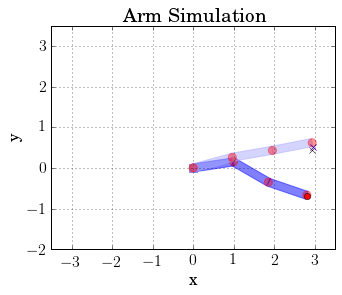

In [5]:
fmdmsds.mode = "exploit"
fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])

mdm = env.getRandomInput()
m,dm = mdm[:3], mdm[3:]
s = arm.gotoTargetJoints(m)
Box2DWorld.plotWorld(ax)
Box2DWorld.plotVectors(ax, arm.getSalient())

# prediction with context
c,c_dims = s, [0,1]   # context x,y pos
sds = fmdmsds.predict_given_context(mdm, c, c_dims)
s_context = sds[:2]
ds_context = sds[2:]

# infer fixing some dimentions
in_dims = env.conf.m_dims + env.conf.s_dims[:2]
out_dims = env.conf.s_dims[2:]
ds_infer = fmdmsds.infer(in_dims, out_dims, mdm+s)

sds_pred = fmdmsds.forward_prediction(mdm)
s_fwd,ds_fwd = sds_pred[:2],sds_pred[2:]

s2 = arm.deltaMotorUpdate(dm)

Box2DWorld.plotAll(ax,color='#aaaaff',centers=arm.getSalient(),xlabel="x",ylabel="y",title="Arm Simulation",mainfont=16)

ax.plot(*s, marker='o', color='red')
ax.plot(*list(np.array(s)+np.array(ds_infer)), marker='x', color='k')
ax.plot(*list(np.array(s_context)+np.array(ds_context)), marker='x', color='r')
ax.plot(*list(np.array(s_fwd)+np.array(ds_fwd)), marker='x', color='b')
plt.grid()
plt.show()

#### sampling the interest model with context

In [3]:
c = [1, 2]    # context
c_dims = [0, 1] # end position's dimensions
ds = fmdmsds_im.sample_given_context(c, c_dims)
print "Sampling interesting goal with end pos context =", c, ": ds=", ds

Sampling interesting goal with end pos context = [1, 2] : ds= [ 0.45650045  0.33974703]


###  $f(M, \Delta M) = \langle S, \Delta S \rangle$ learning from scratch with progress goal babbling


In [3]:
fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])
error,mean_error,mean_var = [],[],[]
c_dims = [0, 1] 
for i in range(1000):
    c = arm.getFinalPos()
    ds_g = fmdmsds_im.sample_given_context(c,c_dims)
    if(fmdmsds.size()>2): mdm = fmdmsds.inverse_prediction(np.hstack((c, ds_g)))           
    else: mdm = env.getRandomInput()
    
    s = arm.gotoTargetJoints(mdm[:3])
    snew = arm.deltaMotorUpdate(mdm[3:])
    ds = np.array(snew) - np.array(s) 
    sds = np.hstack((np.array(s),ds))
    
    fmdmsds.update(mdm, sds)                                        # update the sensorimotor model
    if(fmdmsds.size()>2): 
        VectorFigUtils.error_monitor(ds,ds_g,error,mean_error,mean_var)            
        fmdmsds_im.update(np.hstack((mdm, sds)), np.hstack((mdm, c, ds_g)))   # update the interest model

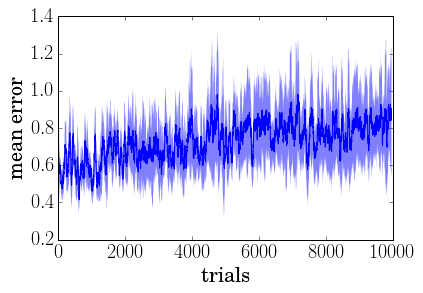

In [4]:
plt.close()
VectorFigUtils.drawPlotXY(range(len(mean_error)),mean_error,mean_var,xlabel="trials",ylabel="mean error")
plt.show()
fig.savefig('imgs/InterestBabblingError.png', dpi=300, format='png')